## 外れ値の影響

アンスコムの例 https://ja.wikipedia.org/wiki/アンスコムの例 を用いて、外れ値の影響を見る。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = sns.load_dataset('anscombe')
# 確認
df

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33
5,I,14.0,9.96
6,I,6.0,7.24
7,I,4.0,4.26
8,I,12.0,10.84
9,I,7.0,4.82


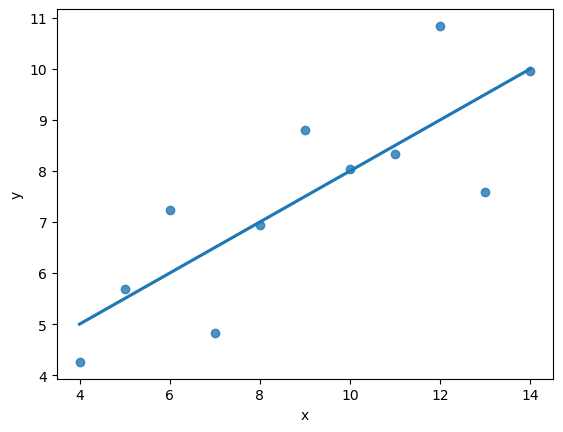

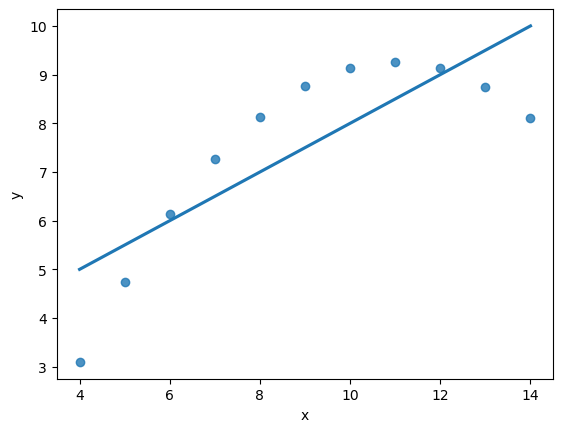

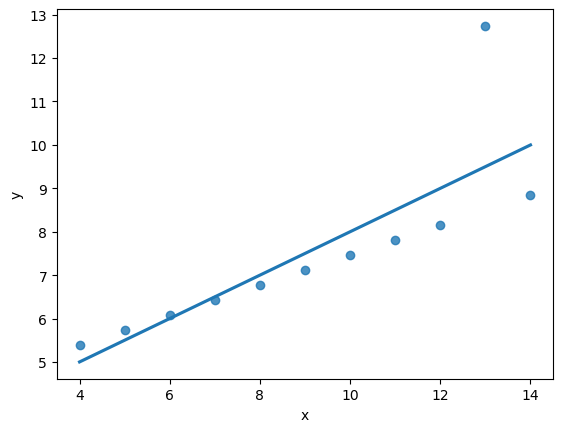

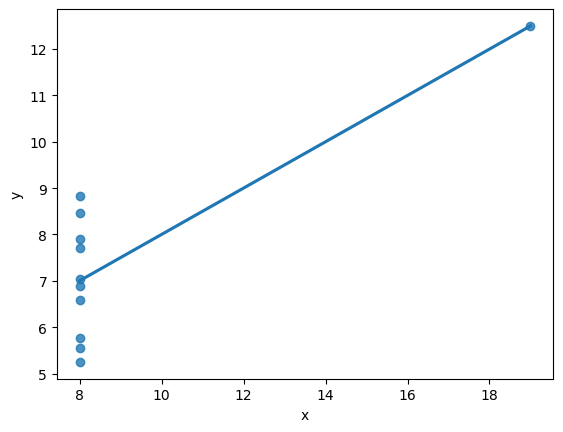

In [2]:
# 各 dataset について散布図に回帰直線を重ねて描画
sns.regplot(x='x', y='y', data=df.query('dataset=="I"'), ci=None)
plt.show()

sns.regplot(x='x', y='y', data=df.query('dataset=="II"'), ci=None)
plt.show()

sns.regplot(x='x', y='y', data=df.query('dataset=="III"'), ci=None)
plt.show()

sns.regplot(x='x', y='y', data=df.query('dataset=="IV"'), ci=None)
plt.show()

In [3]:
# Dataset 1~4 について線形回帰モデルを作成
# 回帰係数、切片、決定係数を表示
from sklearn.linear_model import LinearRegression

def do_simple_regression(df):
    X = df[['x']]
    Y = df['y']

    model = LinearRegression()
    model.fit(X, Y)
    Y_predict = model.predict(X)

    # coefficient: 係数, intercept: 切片, R^2: 決定係数
    print('coefficient={:.3f}, intercept={:.3f}, R^2={:.3f}\n'.format(
        model.coef_[0], model.intercept_, model.score(X, Y)))

for n in ['I', 'II', 'III', 'IV']:
    print('Dataset', n)
    do_simple_regression(df.query('dataset=="{}"'.format(n)))

Dataset I
coefficient=0.500, intercept=3.000, R^2=0.667

Dataset II
coefficient=0.500, intercept=3.001, R^2=0.666

Dataset III
coefficient=0.500, intercept=3.002, R^2=0.666

Dataset IV
coefficient=0.500, intercept=3.002, R^2=0.667



## 外れ値の判定

標準化残差：残差（データと予測値との差分）を標準化（分布を標準偏差をもとに調整）
- 標準化残差の絶対値がある程度の値（例えば 3）を超えていれば外れ値であろうと考えられる

Dataset I


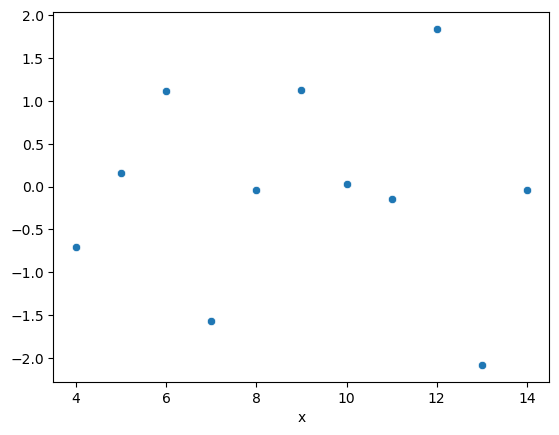

Dataset II


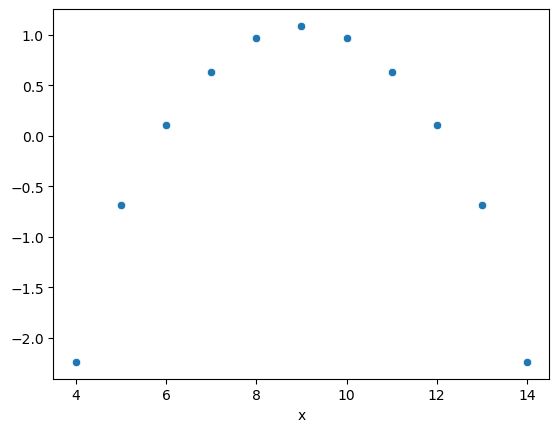

Dataset III


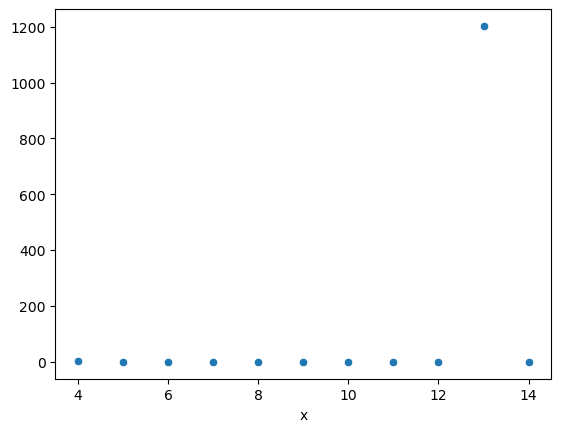

Dataset IV


/Users/kazuya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: divide by zero encountered in true_divide
  return self.resid / sigma / np.sqrt(1 - hii)


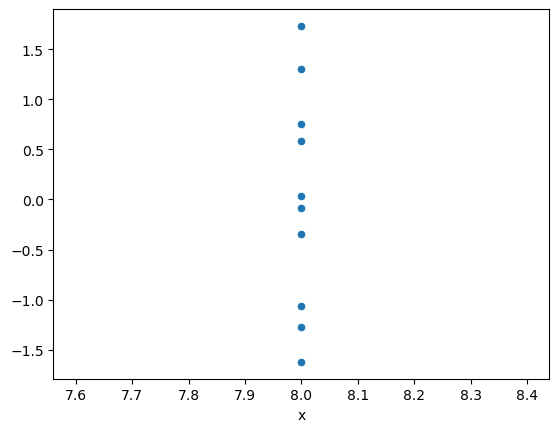

In [4]:
# Scikit-Learn の線形回帰モデルには標準化残差を計算する機能は無いが、
# Statsmodels にはあるため、Statsmodels を使用して計算
# - OLS: Ordinary Least Squares = 最小二乗法
from statsmodels.formula.api import ols

def plot_residuals(df):
    # 線形回帰モデルの作成
    # - formula: '目的変数　~ 説明変数'
    model = ols(formula='y ~ x', data=df)

    # 学習、外れ値の指標を計算
    measures = model.fit().get_influence()

    # X軸をデータの値、Y軸を標準化残差とした散布図
    sns.scatterplot(x=df.x, y=measures.resid_studentized_external)
    plt.show()

for n in ['I', 'II', 'III', 'IV']:
    print('Dataset', n)
    plot_residuals(df.query('dataset=="{}"'.format(n)))

## 外れ値の影響を減らした回帰モデル

特徴選択 (5_2_multiple_regression.ipynb) とは、モデルを単純化するということであり、アルゴリズムでモデルを単純化する方法に正則化がある。
単純化したモデルはばらついたデータにピッタリと合わせることが難しいため、教師データに合わせ過ぎてしまう過学習を避けることができる。
そのため、正則化により、外れ値の影響を減らした回帰モデルを作成することができる。

単純化の度合い（大きいとより単純化）を表すパラメータ alpha は、教師データを学習しテストデータで精度を検証することで、より高い精度になるように設定する。（第9回：予測精度の検証）

In [5]:
from sklearn.linear_model import Ridge

# a (alpha): 大きいとより単純化したモデル
def do_ridge_regression(df, a):
    X_label = 'x'
    Y_label = 'y'
    X = df[[X_label]]
    Y = df[Y_label]

    # 線形回帰モデルの作成
    model = Ridge(alpha=a)

    # モデルの学習
    model.fit(X, Y)

    # coefficient: 係数, intercept: 切片
    print('coefficient={:.3f}, intercept={:.3f}'.format(model.coef_[0], model.intercept_))

    # 散布図
    sns.scatterplot(x=X_label, y=Y_label, data=df)

    # モデルによる予測
    Y_predict = model.predict(X)

    # 回帰直線を描画
    plt.plot(X, Y_predict, color='gray')

coefficient=0.344, intercept=4.408


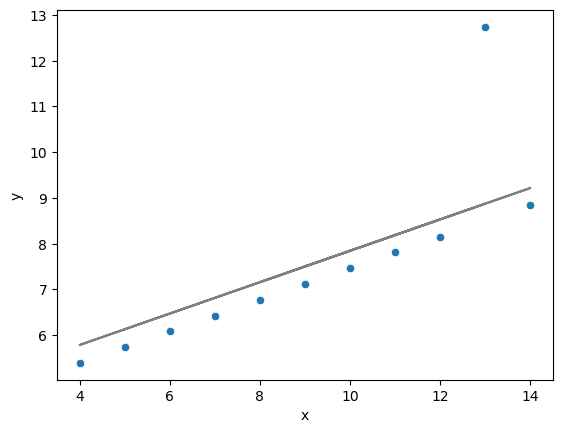

In [6]:
do_ridge_regression(df.query('dataset=="III"'), 50)

coefficient=0.458, intercept=3.377


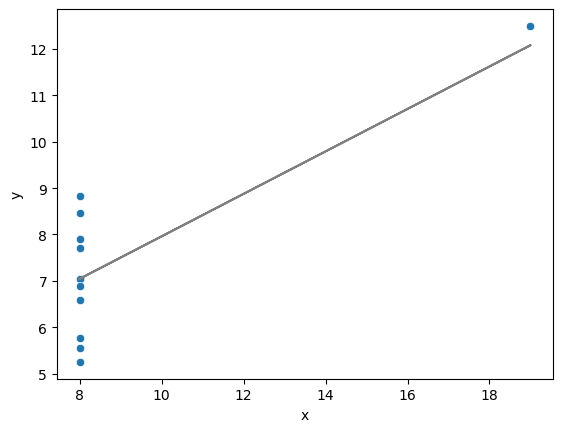

In [7]:
do_ridge_regression(df.query('dataset=="IV"'), 10)